In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.transform import array_bounds
from rasterio.warp import calculate_default_transform, reproject, Resampling
import ultraplot as uplt

## Prepare data

In [2]:
prcp_anom_cols = [f'prcp_anom_{i}' for i in range(1, 25)]
tmax_anom_cols = [f'tmax_anom_{i}' for i in range(1, 25)]
prcp_mean_cols = [f'prcp_mean_{i}' for i in range(1, 25)]
tmax_mean_cols = [f'tmax_mean_{i}' for i in range(1, 25)]

In [3]:
df_2020 = gpd.read_file('./Data/TimeImpacts/time_lags_months_2020.geojson')

df_2021 = gpd.read_file('./Data/TimeImpacts/time_lags_months_2021.geojson')

df_2022 = gpd.read_file('./Data/TimeImpacts/time_lags_months_2022.geojson')

df_2023 = gpd.read_file('./Data/TimeImpacts/time_lags_months_2023.geojson')

In [4]:
def calc_window(df, cols, prefix, i, j):
    # Aggregates specified columns. Return new dataframe and name of column appended.
    agg = df[cols[i]].copy()
    for k in range(i+1, j+1):
        agg += df[cols[k]]
    return agg.rename(f'{prefix}_{i+1}_{j+1}'), f'{prefix}_{i+1}_{j+1}'

In [10]:
df_2021['prcp_anom_10_12'] = calc_window(df_2021, prcp_anom_cols, 'prcp_anom', 9, 11)[0]
df_2021['tmax_anom_10_10'] = calc_window(df_2021, tmax_anom_cols, 'tmax_anom', 9, 9)[0]

df_2023['prcp_anom_10_12'] = calc_window(df_2023, prcp_anom_cols, 'prcp_anom', 9, 11)[0]
df_2023['tmax_anom_10_10'] = calc_window(df_2023, tmax_anom_cols, 'tmax_anom', 9, 9)[0]

In [11]:
print(df_2021['prcp_anom_10_12'].min())
print(df_2021['prcp_anom_10_12'].max())

print(df_2023['prcp_anom_10_12'].min())
print(df_2023['prcp_anom_10_12'].max())

-140.75191758366773
165.34609138241632
-215.52677049114743
115.67410915573849


In [12]:
print(df_2021['tmax_anom_10_10'].min())
print(df_2021['tmax_anom_10_10'].max())

print(df_2023['tmax_anom_10_10'].min())
print(df_2023['tmax_anom_10_10'].max())

-70.07787717147308
67.25568663033575
3.2780384309725346
109.99381391980428


In [13]:
dest_crs = ccrs.AlbersEqualArea(central_longitude=-76.0, central_latitude=42.0,)

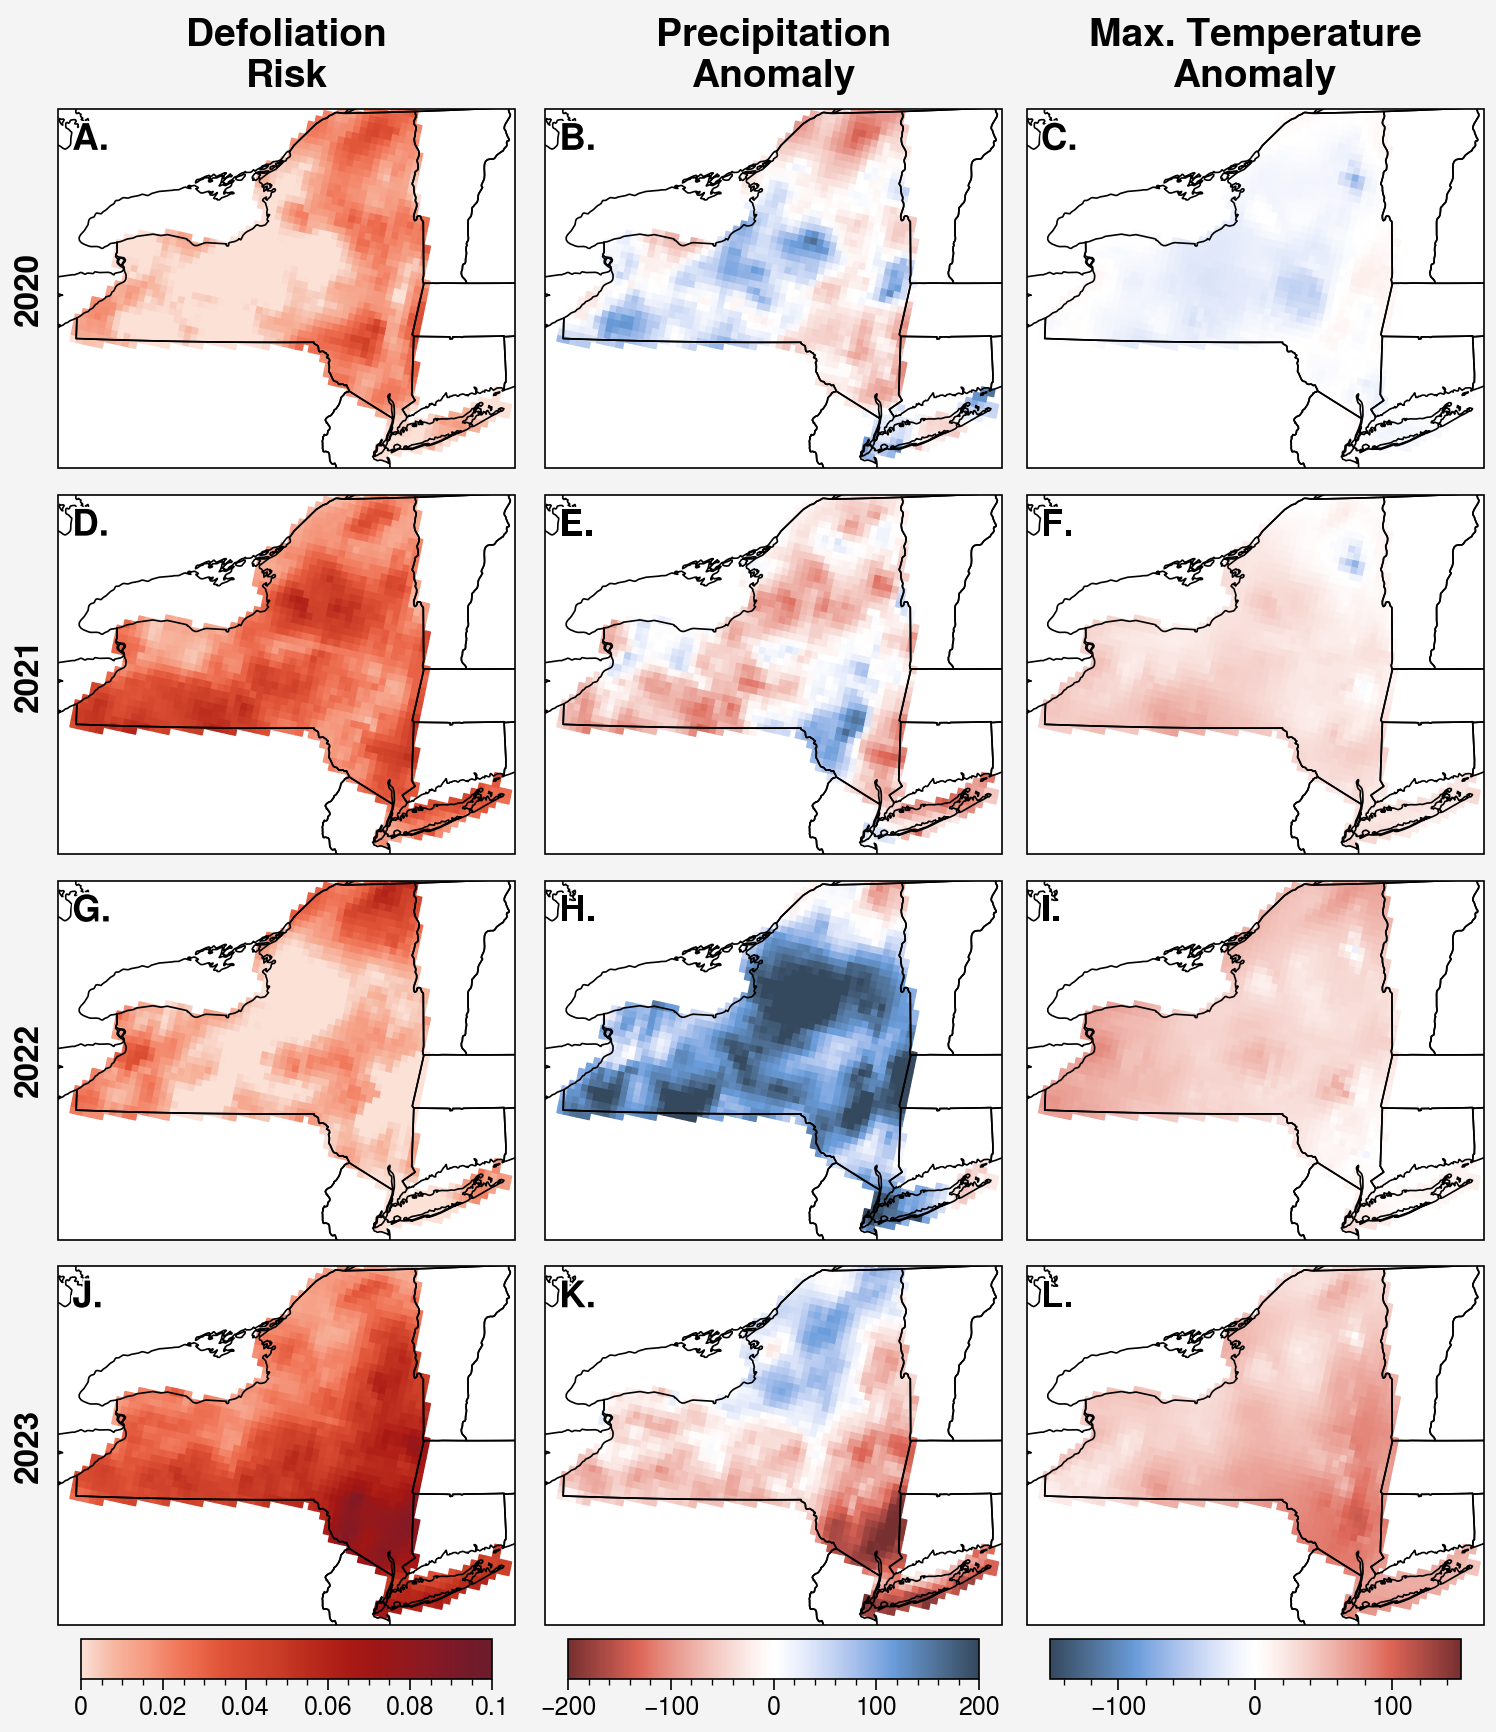

In [15]:
fig, axes = uplt.subplots(ncols=3, nrows=4, figsize=('190mm','220mm'), proj=dest_crs, 
                          facecolor='white', fontsize=12, share=False)

axes.format(abc='A.', abcloc='ul')

norm_defol = plt.colors.Normalize(vmin=0, vmax=0.1)
cmap_defol = uplt.Colormap('Reds3')

norm_prcp = plt.colors.Normalize(vmin=-200, vmax=200)
cmap_prcp = uplt.Colormap('NegPos_r')

norm_tmax = plt.colors.Normalize(vmin=-150, vmax=150)
cmap_tmax = uplt.Colormap('NegPos')

for i, forest in enumerate([df_2020, df_2021, df_2022, df_2023]):
    for row in forest.itertuples():
        defol = cfeature.ShapelyFeature(
            row.geometry,
            ccrs.epsg(5070),
            facecolor=cmap_defol(norm_defol(row.pred_defol_forest_3)),
            edgecolor=cmap_defol(norm_defol(row.pred_defol_forest_3)))
        axes[3*i].add_feature(defol)

        prcp = cfeature.ShapelyFeature(
            row.geometry,
            ccrs.epsg(5070),
            facecolor=cmap_prcp(norm_prcp(row.prcp_anom_10_12)),
            edgecolor=cmap_prcp(norm_prcp(row.prcp_anom_10_12)))
        axes[3*i + 1].add_feature(prcp)

        tmax = cfeature.ShapelyFeature(
            row.geometry,
            ccrs.epsg(5070),
            facecolor=cmap_tmax(norm_tmax(row.tmax_anom_10_10)),
            edgecolor=cmap_tmax(norm_tmax(row.tmax_anom_10_10)))
        axes[3*i + 2].add_feature(tmax)

axes[9].colorbar(cmap_defol, loc='b', length=0.9, vmin=norm_defol.vmin, vmax=norm_defol.vmax)
axes[10].colorbar(cmap_prcp, loc='b', length=0.9, vmin=norm_prcp.vmin, vmax=norm_prcp.vmax)
axes[11].colorbar(cmap_tmax, loc='b', length=0.9, vmin=norm_tmax.vmin, vmax=norm_tmax.vmax)
        
axes.set_extent([-80, -71.7, 40.3, 45], crs=ccrs.PlateCarree())
axes.add_feature(cfeature.STATES)
axes.format(
    toplabels=('Defoliation\nRisk', 
                'Precipitation\nAnomaly', 
                'Max. Temperature\nAnomaly'),
    toplabels_kw={'size':'14', 'ha':'center'},
    leftlabels=('2020', '2021', '2022', '2023'),
    leftlabels_kw={'size':'12', 'ma':'center'},
    grid=False, 
    facecolor='white')

fig.savefig('./Figures/LagMaps/PredAnomalyPlots.png')